In [1]:
import sys
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
feature_list_filename = "/home/ubuntu/HeLa_20KInt/HeLa_20KInt-feature-list.csv"
feature_list_df = pd.read_csv(feature_list_filename)

In [3]:
feature_list_df.head()

,feature_id,charge_state,monoisotopic_mass,feature_centroid_scan,feature_centroid_rt,feature_centroid_mz,feature_start_rt,feature_end_rt,feature_scan_lower,feature_scan_upper,...,base_peak_scan_lower,base_peak_scan_upper,base_peak_centroid_rt,base_peak_std_dev_rt,base_peak_rt_lower,base_peak_rt_upper,base_peak_centroid_mz,base_peak_std_dev_mz,base_peak_mz_lower,base_peak_mz_upper
0,1,3,1960.915588,680.366484,4013.127018,654.717577,4005.957188,4021.318195,668,688,...,668,688,4013.130741,3.845270,4005.957188,4021.318195,654.645757,0.002612,654.619261,654.675743
1,2,2,1247.602054,574.224714,1085.766969,625.127677,1075.177570,1097.628037,565,585,...,565,585,1085.746282,2.179954,1075.177570,1097.628037,624.809083,0.002324,624.778556,624.833736
2,3,2,1789.900380,379.472823,4433.432999,896.216859,4421.919624,4439.635599,367,387,...,367,387,4436.255100,2.552869,4421.919624,4439.635599,896.459161,0.003005,896.413464,896.498444
3,4,2,1405.719333,527.432220,4034.358108,704.126734,4022.496117,4044.962866,519,539,...,519,539,4034.498268,3.537136,4024.859526,4044.962866,703.867085,0.005701,703.834050,703.900983
4,5,2,2214.082282,231.310785,5002.872698,1108.270682,4991.075059,5008.786578,221,241,...,221,241,5002.369948,1.875718,4991.075059,5008.786578,1108.049241,0.003916,1107.997794,1108.087022


In [4]:
feature_list_df['mono_peak_fwhm_scan_lower'] = feature_list_df.mono_peak_centroid_scan - (2.355/2*feature_list_df.mono_peak_std_dev_scan)
feature_list_df['mono_peak_fwhm_scan_upper'] = feature_list_df.mono_peak_centroid_scan + (2.355/2*feature_list_df.mono_peak_std_dev_scan)

In [5]:
feature_list_df['base_peak_fwhm_scan_lower'] = feature_list_df.base_peak_centroid_scan - (2.355/2*feature_list_df.base_peak_std_dev_scan)
feature_list_df['base_peak_fwhm_scan_upper'] = feature_list_df.base_peak_centroid_scan + (2.355/2*feature_list_df.base_peak_std_dev_scan)

In [6]:
feature_list_df[['base_peak_fwhm_scan_lower','base_peak_fwhm_scan_upper','base_peak_scan_lower','base_peak_scan_upper']].head()

,base_peak_fwhm_scan_lower,base_peak_fwhm_scan_upper,base_peak_scan_lower,base_peak_scan_upper
0,674.107077,686.941959,668,688
1,567.336306,580.910679,565,585
2,372.526575,387.271590,367,387
3,521.964807,534.363408,519,539
4,223.343388,237.734032,221,241


In [7]:
len(feature_list_df[feature_list_df.mono_peak_id!=feature_list_df.base_peak_id])

41379

In [8]:
instrument_db_name = '/home/ubuntu/HeLa_20KInt_2KIT_Slot1-46_01_1179.d/analysis.tdf'
db_conn = sqlite3.connect(instrument_db_name)
isolation_window_df = pd.read_sql_query("select * from PasefFrameMsMsInfo", db_conn)
db_conn.close()

In [9]:
isolation_window_df.head()

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,CollisionEnergy,Precursor
0,3,507,532,742.744835,2.427448,36.96,1
1,3,549,574,709.235759,2.092358,36.96,2
2,3,602,627,594.235088,2.000000,36.96,3
3,3,643,668,503.527768,2.000000,36.96,4
4,3,684,709,552.063870,2.000000,31.92,5


In [10]:
len(isolation_window_df)

486938

In [11]:
converted_db_name = '/home/ubuntu/HeLa_20KInt/HeLa_20KInt.sqlite'
db_conn = sqlite3.connect(converted_db_name)
frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties", db_conn)
db_conn.close()

In [12]:
frame_properties_df.head()

,frame_id,retention_time_secs
0,1,0.699237
1,2,0.801334
2,3,0.989283
3,4,1.096483
4,5,1.203557


In [13]:
isolation_window_df = pd.merge(isolation_window_df, frame_properties_df, how='left', left_on=['Frame'], right_on=['frame_id'])
isolation_window_df.drop(['frame_id', 'CollisionEnergy'], axis=1, inplace=True)

In [14]:
isolation_window_df.head(10)

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs
0,3,507,532,742.744835,2.427448,1,0.989283
1,3,549,574,709.235759,2.092358,2,0.989283
2,3,602,627,594.235088,2.000000,3,0.989283
3,3,643,668,503.527768,2.000000,4,0.989283
4,3,684,709,552.063870,2.000000,5,0.989283
5,3,765,790,416.202091,2.000000,6,0.989283
6,3,806,831,372.838373,2.000000,7,0.989283
7,3,868,893,367.323799,2.000000,8,0.989283
8,4,507,532,742.744835,2.427448,1,1.096483
9,4,568,593,598.471759,2.000000,9,1.096483


In [15]:
isolation_window_df['mz_lower'] = isolation_window_df.IsolationMz - (isolation_window_df.IsolationWidth / 2)
isolation_window_df['mz_upper'] = isolation_window_df.IsolationMz + (isolation_window_df.IsolationWidth / 2)

In [16]:
isolation_window_df.head(10)

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs,mz_lower,mz_upper
0,3,507,532,742.744835,2.427448,1,0.989283,741.531111,743.958559
1,3,549,574,709.235759,2.092358,2,0.989283,708.189580,710.281938
2,3,602,627,594.235088,2.000000,3,0.989283,593.235088,595.235088
3,3,643,668,503.527768,2.000000,4,0.989283,502.527768,504.527768
4,3,684,709,552.063870,2.000000,5,0.989283,551.063870,553.063870
5,3,765,790,416.202091,2.000000,6,0.989283,415.202091,417.202091
6,3,806,831,372.838373,2.000000,7,0.989283,371.838373,373.838373
7,3,868,893,367.323799,2.000000,8,0.989283,366.323799,368.323799
8,4,507,532,742.744835,2.427448,1,1.096483,741.531111,743.958559
9,4,568,593,598.471759,2.000000,9,1.096483,597.471759,599.471759


In [46]:
isolation_window_df['feature_id'] = 0

# For each feature, find all the isolation windows which would fit the feature's monoisotopic and base peaks
for idx in range(len(feature_list_df)):
    feature_df = feature_list_df.iloc[idx]
    feature_id = feature_df.feature_id.astype(int)
    indexes = isolation_window_df.index[
                        (
                            ((feature_df.mono_peak_scan_upper >= isolation_window_df.ScanNumBegin) &
                             (feature_df.mono_peak_scan_upper <= isolation_window_df.ScanNumEnd)) |
                            ((feature_df.mono_peak_scan_lower >= isolation_window_df.ScanNumBegin) &
                            (feature_df.mono_peak_scan_lower <= isolation_window_df.ScanNumEnd))
                        ) &
                        (feature_df.mono_peak_centroid_mz >= isolation_window_df.mz_lower) &
                        (feature_df.mono_peak_centroid_mz <= isolation_window_df.mz_upper) &
                        (feature_df.mono_peak_rt_lower <= isolation_window_df.retention_time_secs) &
                        (feature_df.mono_peak_rt_upper >= isolation_window_df.retention_time_secs)
                       ]
    if len(indexes) > 0:
        isolation_window_df.loc[indexes,'feature_id'] = feature_id

In [47]:
feature_isolation_matches_df = pd.merge(feature_list_df, isolation_window_df, how='right', left_on=['feature_id'], right_on=['feature_id'])

In [48]:
feature_isolation_matches_df.head()

,feature_id,charge_state,monoisotopic_mass,feature_centroid_scan,feature_centroid_rt,feature_centroid_mz,feature_start_rt,feature_end_rt,feature_scan_lower,feature_scan_upper,...,base_peak_fwhm_scan_upper,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs,mz_lower,mz_upper
0,34,3.0,2227.223439,446.949144,5574.123577,743.625599,5565.209670,5587.631865,438.0,458.0,...,454.898617,51989,421,446,743.512336,2.435123,222081,5585.918437,742.294774,744.729897
1,60,3.0,1767.981504,693.999467,4855.758839,590.626521,4844.676321,4867.110040,685.0,705.0,...,702.063280,45149,677,702,590.661871,2.000000,173852,4849.076479,589.661871,591.661871
2,60,3.0,1767.981504,693.999467,4855.758839,590.626521,4844.676321,4867.110040,685.0,705.0,...,702.063280,45150,677,702,590.661871,2.000000,173852,4849.183076,589.661871,591.661871
3,60,3.0,1767.981504,693.999467,4855.758839,590.626521,4844.676321,4867.110040,685.0,705.0,...,702.063280,45171,678,703,590.664798,2.000000,173961,4851.437332,589.664798,591.664798
4,68,2.0,1505.747245,457.823503,4442.957084,754.187904,4433.733502,4453.805803,447.0,467.0,...,464.456356,41309,445,470,754.335170,2.543352,152450,4436.848388,753.063494,755.606846


In [49]:
len(feature_isolation_matches_df.feature_id.unique())

82205

In [50]:
len(feature_list_df.feature_id.unique())

167291

In [51]:
features_with_isolation_matches_df = pd.merge(feature_list_df, isolation_window_df, how='left', left_on=['feature_id'], right_on=['feature_id'])

In [52]:
len(features_with_isolation_matches_df)

280309

In [53]:
features_with_isolation_matches_df = features_with_isolation_matches_df.drop_duplicates(['feature_id'])

In [54]:
len(features_with_isolation_matches_df)

167291

In [55]:
features_with_isolation_matches_df.Frame.isna().sum()

85087

In [56]:
features_with_isolation_matches_df.dropna(subset = ['Frame'],inplace=True)

In [57]:
len(features_with_isolation_matches_df)

82204

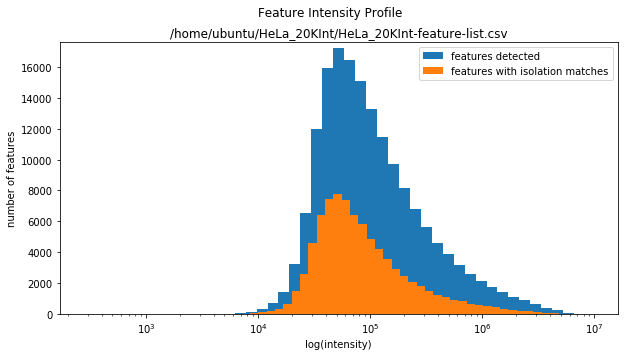

In [58]:
f, ax1 = plt.subplots()
logbins = np.geomspace(feature_list_df.feature_summed_intensity.min(), feature_list_df.feature_summed_intensity.max(), 50)
plt.hist(feature_list_df.feature_summed_intensity, bins=logbins, label="features detected")
logbins = np.geomspace(features_with_isolation_matches_df.feature_summed_intensity.min(), features_with_isolation_matches_df.feature_summed_intensity.max(), 50)
plt.hist(features_with_isolation_matches_df.feature_summed_intensity, bins=logbins, label="features with isolation matches")
f.set_figheight(5)
f.set_figwidth(10)
plt.xscale('log')
plt.xlabel('log(intensity)')
plt.ylabel('number of features')
plt.legend(loc='best')
plt.margins(0.02)
plt.suptitle("Feature Intensity Profile")
plt.title('{}'.format(feature_list_filename))
plt.show()